# Exploratory Data Analysis

After gathering our neccessary data, the next step was to explore the data, to observe what information might be useful and organize it in a format ready for modeling. 

In [2]:
import random
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import Imputer
import math

In [3]:
green_col = np.divide([30,215,96],255)
black_col = [0,0,0]
gray_col = np.divide([150,150,150],255)
light_gray_col = np.divide([236,235,232],255)
white_col =  np.divide([255,255,255],255)
med_gray_col = np.divide([80,80,80],255)

colors = [green_col, black_col, gray_col, light_gray_col, white_col]

afont = {'fontname':'AppleGothic'}
hfont = {'fontname':'Helvetica'}
ifont = {'fontname': 'Impact'}
arfont = {'fontname': 'Arial'}
ofont = {'fontname': 'Osaka'}
sfont = {'fontname': 'STHeiti'}
hirafont = {'fontname': 'Hiragino Kaku Gothic ProN'}

In [4]:
sns.set_style('whitegrid')

## Predictor Variables

The first step to cleaning the data was to first examine the dataframe for any problematic or duplicate columns. 

In [5]:
data= pd.read_csv('data/Final_Dataframe.csv')

In [6]:
# A train/test split is constructed where 90% of the subsample is 
# the train data set and 10% the test data set.

# Set train and test sizes
train_size = 0.9
test_size = 1-train_size

# Function to return random train and test sets
def data_splitter(df, train, validate=False, seed=9001):
    
    if validate:
        np.random.seed(seed)
        perm = np.random.permutation(df.index)
        m = len(df)
        train_end = int(train * m)
        validate_end = int(validate * m) + train_end
        train = df.ix[perm[:train_end]]
        validate = df.ix[perm[train_end:validate_end]]
        test = df.ix[perm[validate_end:]]
        return train, validate, test
    else:
        np.random.seed(seed)
        perm = np.random.permutation(df.index)
        m = len(df)
        train_end = int(train * m)
        train = df.ix[perm[:train_end]]
        test = df.ix[perm[train_end:]]
        return train, test

In [7]:
# Create train and test dataframes from subsample
train_df, test_df = data_splitter(data, train_size)

# Return shapes of train and test dataframes
print("Train Size: {}".format(train_df.shape))
print("Test Size: {}".format(test_df.shape))

Train Size: (1278, 950)
Test Size: (142, 950)


In [8]:
# Find Missing Columns
null_vals = train_df.isnull().sum()
missing_vals = null_vals[null_vals > 0].index.tolist() 

In [9]:
# Median imputation of missing values
imp = Imputer(missing_values='NaN', strategy='median', axis=1)
train_df = pd.DataFrame(imp.fit_transform(train_df), columns=data.columns)
test_df = pd.DataFrame(imp.transform(test_df), columns=data.columns)

In [10]:
# Split training and test data
train_df = train_df[train_df['Followers'] != 0]
test_df = test_df[test_df['Followers'] != 0]

In [11]:
# Final step: create y_train/x_train and y_test/x_test dataframes

# Initialize the training data
y_train = np.log(train_df['Followers'])
x_train = train_df.drop('Followers', axis=1)

# Initialize the testing data
y_test = np.log(test_df['Followers'])
x_test = test_df.drop('Followers', axis=1)

In [12]:
numerical_columns = []
top_artist_count_columns = []
genre_columns = []

for i in data.columns:
    
    if 'mean' in i or 'std' in i:
        numerical_columns.append(i)
    elif i[:2]=='to':
        top_artist_count_columns.append(i)
    elif (i[0].isalpha()==False and i[0]!=2):
        genre_columns.append(i)


title_columns = ['Str_Best','Str_Workout','Str_Party','Str_Chill','Str_Acoustic','Str_2000s','Str_1990s','Str_1980s',
                'Str_1970s','Str_1960s']

interaction_columns = ['house_acousticness_mean','hip hop_acousticness_std','pop_liveness_std','dance_liveness_std',
                      'r&b_acousticness_std','rap_energy_std','rap_key_std','acoustic_acousticness_std','acoustic_acousticness_mean',
                      'acoustic_energy_std','acoustic_key_std','soul_acousticness_std']

artist_columns = list(set(data.columns)-set(numerical_columns)-set(title_columns)-set(interaction_columns)-
                      set(top_artist_count_columns)-set(genre_columns))

In [13]:
# Extracting numerical columns
numerical_columns = []
for i in train_df.columns:
    if 'mean' in i or 'std' in i:
        numerical_columns.append(i)
        if (train_df[[i]].values==0).all():
            train_df = train_df.drop([i], axis=1)
            test_df = test_df.drop([i], axis=1)

# The numerical columns are standardized next
mean = train_df[numerical_columns].mean()
std = train_df[numerical_columns].std()

train_df[numerical_columns] = (train_df[numerical_columns] - mean)/std
test_df[numerical_columns] = (test_df[numerical_columns] - mean)/std

## Response Variable

The response variable is the number of followers of different playlists. Because there are cases in which some playlists accumulate an extremely large number of followers, it was observed that the distribution of the response variable is highly right skewed. In order to fix fo this, a log transform was applied and the playlists with no followers were discarded. As can be seen by the figure below, logging the number of followers for the dataset creates a more normal distribution, as well as Performing a log trasnformation helps with visualizing the data, as well as with modelling and making predictions. 

In [14]:
before_transform = np.exp(y_train)

def hist_response():
    f, axarr = plt.subplots(1,2, figsize=(15,8))

    sns.distplot(before_transform, color = black_col, ax = axarr[0])
    axarr[0].set_xlabel('Followers', fontsize=12, **arfont, color = med_gray_col)
    axarr[0].set_ylabel('Counts',fontsize=12, **arfont, color = med_gray_col)
    axarr[0].set_title('Followers (Before Log)', fontsize = 22, color=gray_col)
    
    sns.distplot(y_train, color = black_col, ax = axarr[1])
    axarr[1].set_xlabel('Log Followers', fontsize=12, **arfont, color = med_gray_col)
    axarr[1].set_ylabel('Counts',fontsize=12, **arfont, color = med_gray_col)
    axarr[1].set_title('Followers (After Log)', fontsize = 22, color=gray_col)

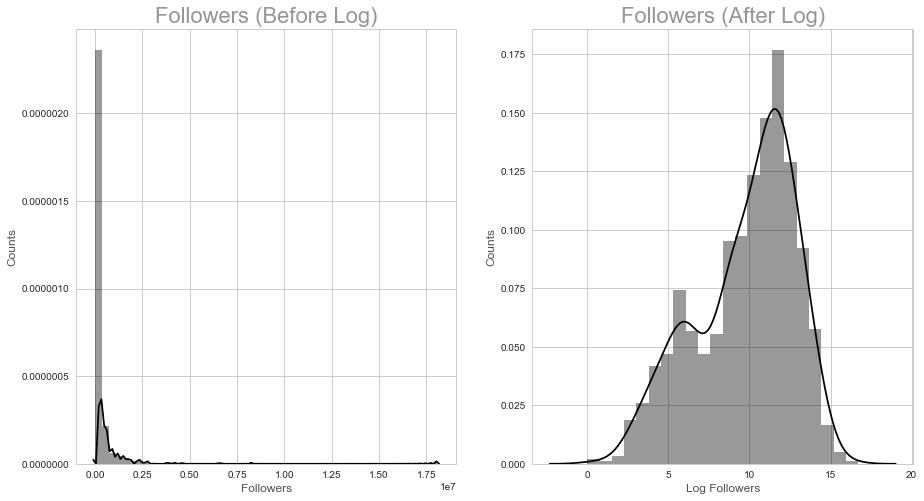

In [15]:
hist_response()

## Audio Features

Audio features are available on Spotify for each track. In total, eleven audio features were extracted for each track. For each playlist, the means and standard deviations of those features across the tracks in the playlist were used. 


These features are descriptors of the audio signals of each track. The full list of audio features and explanations for each are available in: 
https://developer.spotify.com/web-api/get-audio-features/


Descriptions for the features shown below:

**Energy:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.

**Liveness:** Detects the presence of an audience in the recording.

**Tempo:** The overall estimated tempo of a track in beats per minute (BPM).

**Valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).


When viewed in scatterplots against the response variable, it can be seen that certain features seem to contain useful information. In particular, it seems that songs with high liveness (in which we can hear an audience in the recording)and songs with high valence (positive sounding) tend to have fewer followers.

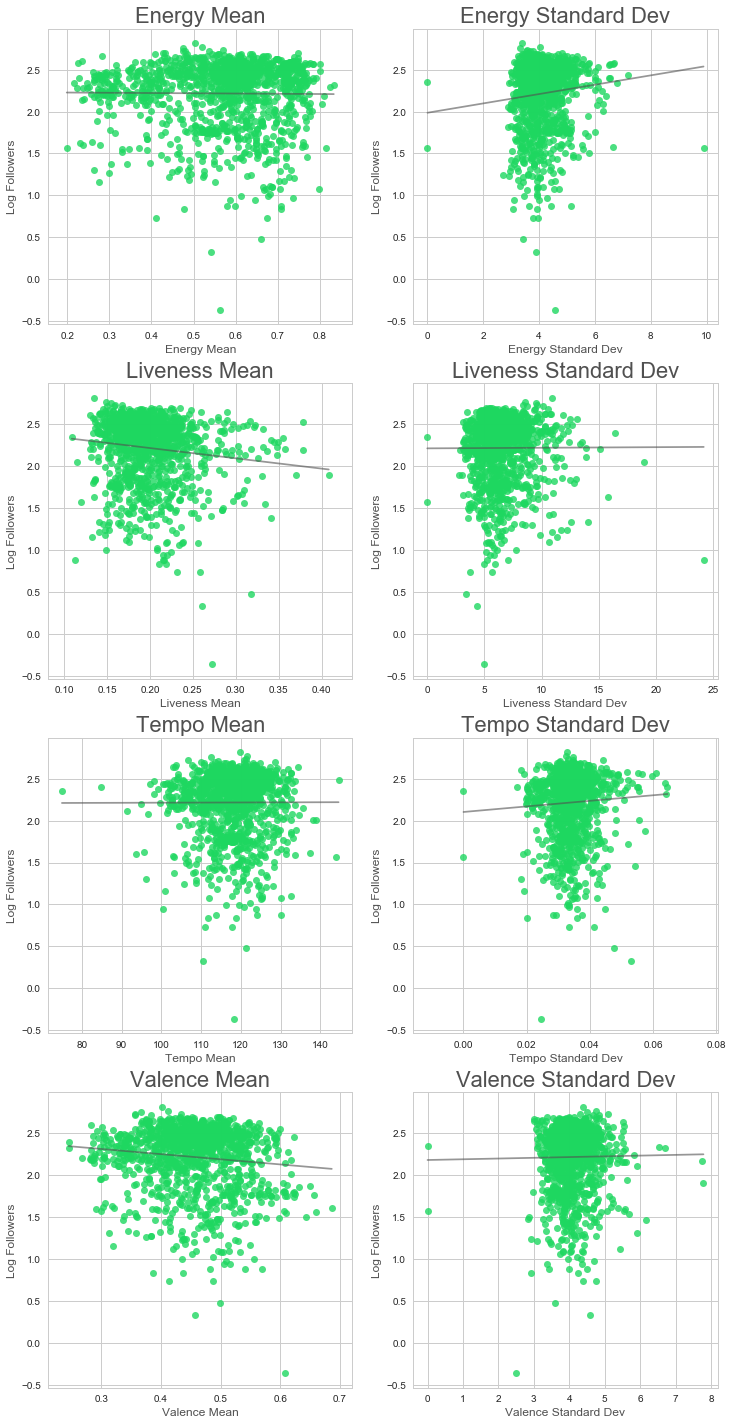

In [16]:
f, axarr = plt.subplots(4,2, figsize=(12,25))

plot_feats = ['energy_mean','energy_std','liveness_mean','liveness_std','tempo_mean','tempo_std','valence_mean','valence_std']

plot_titles = ['Energy Mean','Energy Standard Dev','Liveness Mean','Liveness Standard Dev','Tempo Mean',
               'Tempo Standard Dev','Valence Mean','Valence Standard Dev']


for i in range(len(plot_feats)):
    m = i%2
    n = math.floor(i/2)
    feat = plot_feats[i]
    
    sns.regplot(x=x_train[feat], y=np.log(y_train), color = green_col, ax=axarr[n,m])           
    #axarr[n,m].scatter(x_train[feat],np.log(y_train), s =20, color = green_col, alpha = 0.6)

    y = np.log(y_train[y_train>0])
    x = x_train[feat][y_train>0]
    z = np.polyfit(x,y, 1)
    p = np.poly1d(z)
    x_plot = np.linspace(min(x), max(x), 30)
    
    axarr[n,m].plot(x_plot,p(x_plot), '-', c = med_gray_col, alpha = 0.6)
    #axarr[n,m].set_facecolor(light_gray_col)
    #axarr[n,m].grid(True, color = white_col)
    axarr[n,m].set_xlabel(plot_titles[i], fontsize=12, **arfont, color = med_gray_col)
    axarr[n,m].set_ylabel('Log Followers',fontsize=12, **arfont, color = med_gray_col)
    axarr[n,m].set_title(plot_titles[i], fontsize = 22, color=med_gray_col)

In [17]:
# pip install plotly
# pip install pandas_datareader
import plotly
plotly.__version__
plotly.tools.set_credentials_file(username='jeehye95', api_key='RgxQ1hKEQqYD46OsbCdY')

import plotly.plotly as py
import plotly.graph_objs as go 

from datetime import datetime
#import pandas_datareader as web

energy_mean = go.Scatter(x=x_train['energy_mean'],
                        y=y_train,
                        name='energy_mean',
                        mode = 'markers',
                        marker=dict(color='#191995'))

valence_mean = go.Scatter(x=x_train['valence_mean'],
                        y=y_train,
                        name='valence_mean',
                        mode = 'markers',
                        marker=dict(color='#934552'))

acousticness_mean = go.Scatter(x=x_train['acousticness_mean'],
                        y=y_train,
                        name='acousticness_mean',
                        mode = 'markers',
                        marker=dict(color='#cecee7'))

liveness_mean = go.Scatter(x=x_train['liveness_mean'],
                        y=y_train,
                        name='liveness_mean',
                        mode = 'markers',
                        marker=dict(color='#8b7d6b'))

key_mean = go.Scatter(x=x_train['key_mean'],
                        y=y_train,
                        name='key_mean',
                        mode = 'markers',
                        marker=dict(color='#a8dae2'))

#trace_high_avg = go.Scatter(x=df.index,
#                            y=[df.High.mean()]*len(df.index),
#                            name='High Average',
#                            visible=False,
#                            line=dict(color='#33CFA5', dash='dash'))

#trace_low = go.Scatter(x=df.index,
#                       y=df.Low,
#                       name='Low',
#                       line=dict(color='#F06A6A'))

#trace_low_avg = go.Scatter(x=df.index,
#                           y=[df.Low.mean()]*len(df.index),
#                           name='Low Average',
#                           visible=False,
#                           line=dict(color='#F06A6A', dash='dash'))

data1 = [energy_mean, valence_mean, acousticness_mean, liveness_mean, key_mean]

updatemenus = list([
    dict(active=-1,
         buttons=list([   
            dict(label = 'energy_mean',
                 method = 'update',
                 args = [{'visible': [True, False, False, False, False]},
                         {'title': 'energy mean',
                          }]),
             dict(label = 'valence_mean',
                 method = 'update',
                 args = [{'visible': [False, True, False, False, False]},
                         {'title': 'valence mean',
                          }]),
             dict(label = 'acousticness_mean',
                 method = 'update',
                 args = [{'visible': [False, False, True, False, False]},
                         {'title': 'acousticness mean',
                          }]),
             dict(label = 'liveness_mean',
                 method = 'update',
                 args = [{'visible': [False, False, False, True, False]},
                         {'title': 'liveness mean',
                          }]),
             dict(label = 'key_mean',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, True]},
                         {'title': 'key mean',
                          }]),
            #dict(label = 'Low',
            #     method = 'update',
            #     args = [{'visible': [False, False, True, True]},
            #             {'title': 'Yahoo Low',
            #              'annotations': low_annotations}]),
            #dict(label = 'Both',
            #     method = 'update',
            #     args = [{'visible': [True, True, True, True]},
            #             {'title': 'Yahoo',
            #              'annotations': high_annotations+low_annotations}]),
            #dict(label = 'Reset',
            ##     method = 'update',
            #     args = [{'visible': [True, False, True, False]},
            #             {'title': 'Yahoo',
            #              'annotations': []}])
        ]),
             )
])

layout = dict(title='Audio Features', showlegend=True,
              updatemenus=updatemenus)

fig = dict(data=data1, layout=layout)


py.iplot(fig, filename='update_dropdown')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jeehye95/0 or inside your plot.ly account where it is named 'update_dropdown'


## Genre Features

Genre features describe the genres of songs that the artists included in the playlist create. The following bar chart shows the mean number of playlist followers for the most common genres. (Common genres refer the the genres that many playlists fall under). It can be observed that **rap** has the highest number of mean followers. It can be observed that all of the common genres have at least 200,000 followers, which is at the high end of the spectrum.  

In [18]:
data['Followers_log'] = np.log(data['Followers'])

In [19]:
genres_counts = pd.DataFrame(np.zeros((len(genre_columns),4)), 
                             columns=['Num_tracks','Mean_Follow','Total_Follow','Std_Follow'])
genres_counts.index = genre_columns


print("Counts for Significant Genres: \n")

for pred in genre_columns:
    
    pred_cols = data[data[pred]==1]
    follow = pred_cols['Followers']
    mean_followers = np.mean(follow[follow>0])
    total_followers = sum(follow)
    
    genres_counts['Num_tracks'][pred] = sum(data[pred])
    genres_counts['Mean_Follow'][pred] = round(mean_followers)
    genres_counts['Total_Follow'][pred] = round(total_followers)
    genres_counts['Std_Follow'][pred]= np.std(follow[follow>0])

genres_counts = genres_counts.sort_values(['Mean_Follow'], ascending=False)
genres_counts = genres_counts[(genres_counts['Mean_Follow']>200000)]
genres_counts_sub = genres_counts[genres_counts['Num_tracks']>900]
genres_counts_sub2 = genres_counts[genres_counts['Num_tracks']>500]
print(genres_counts_sub)

Counts for Significant Genres: 

                     Num_tracks  Mean_Follow  Total_Follow     Std_Follow
 'rap'                    967.0     265222.0   251430004.0  821717.826915
'dance pop'               956.0     255620.0   239515624.0  825409.275100
 'pop rap'               1030.0     254605.0   256896826.0  807502.717628
 'pop'                   1071.0     245154.0   256921483.0  793449.816572
 'modern rock'           1128.0     245142.0   271862478.0  772018.721861
 'rock'                   911.0     240249.0   214062114.0  787293.952886
 'indietronica'           934.0     240152.0   219979339.0  761555.292875
 'indie folk'             916.0     233859.0   210706655.0  526542.324277
 'classic rock'           917.0     233528.0   209708010.0  759646.322334
 'indie rock'             933.0     230190.0   210623582.0  523374.742379
'no_genre'               1271.0     228706.0   285425695.0  732681.606393
 'nu metal'               917.0     228482.0   206090832.0  544527.585598
'alte

In [27]:
genres_counts_sub = genres_counts_sub.reset_index()

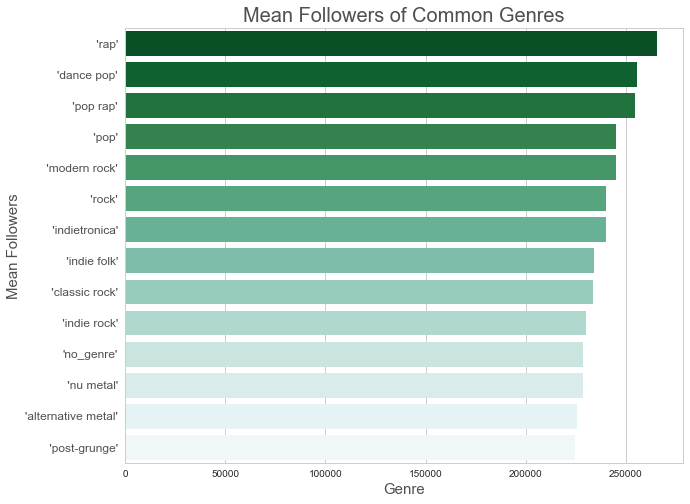

In [40]:
# Plot genres
fig, ax1 = plt.subplots(1, 1, figsize = (10, 8))
ax1 = sns.barplot(x='Mean_Follow' , y ='index', data=genres_counts_sub, palette="BuGn_r")
ax1.set_xlabel('Genre', fontsize=15, **arfont, color = med_gray_col)
ax1.set_ylabel('Mean Followers',fontsize=15, **arfont, color = med_gray_col)
ax1.set_yticklabels(genres_counts_sub['index'], fontsize=12, color=med_gray_col)
ax1.set_title('Mean Followers of Common Genres', fontsize = 20, color=med_gray_col);

The following histogram shows the distribution of two very different genres- alternative rock and dance pop. 
Both genres have ore than 500 tracks, but have a very differing number of playlist followers. 


**Genre:** 'alternative rock'

**Followers:** 219751.0

**Num Tracks:** 691.0

---------------------------------------------

**Genre:**  'dance pop'

**Followers:** 301507.0

**Num Tracks:** 614.0

In [37]:
min_follow_genre = genres_counts_sub2['Mean_Follow'].idxmin(axis=1, skipna=True)
min_follow = genres_counts_sub2['Mean_Follow'][min_follow_genre]
min_follow_num_tracks = genres_counts_sub2['Num_tracks'][min_follow_genre]

print("Least Followers (with at least 500 tracks): ")
print("Genre: " + min_follow_genre)
print("Followers: " +  str(min_follow))
print("Num Tracks: " +  str(min_follow_num_tracks))

max_follow_genre = genres_counts_sub2['Mean_Follow'].idxmax(axis=1, skipna=True)
max_follow = genres_counts_sub2['Mean_Follow'][max_follow_genre]
max_follow_num_tracks = genres_counts_sub2['Num_tracks'][max_follow_genre]
print("---------------------------------------------")
print("Most Followers (with at least 500 tracks): ")
print("Genre: " + max_follow_genre)
print("Followers: " +  str(max_follow))
print("Num Tracks: " +  str(max_follow_num_tracks))

min_index = data[data[min_follow_genre]==1]
min_follow_hist = min_index['Followers']

max_index = data[data[max_follow_genre]==1]
max_follow_hist = max_index['Followers']

no_index = data[data["'no_genre'"]==1]
no_follow_hist = no_index['Followers']

Least Followers (with at least 500 tracks): 
Genre: 'alternative rock'
Followers: 219751.0
Num Tracks: 691.0
---------------------------------------------
Most Followers (with at least 500 tracks): 
Genre:  'dance pop'
Followers: 301507.0
Num Tracks: 614.0


In [50]:
def hist_figures():
    plt.figure(figsize=(10,8))
    plt.hist(np.log(min_follow_hist[min_follow_hist!=0]),  alpha=0.6, label=min_follow_genre, color = black_col)
    plt.hist(np.log(max_follow_hist[max_follow_hist!=0]), alpha=0.6, label=max_follow_genre, color = green_col)
    plt.legend(loc='upper left', fontsize=14)
    plt.xlabel('Mean Log Followers', fontsize=14, color = med_gray_col)
    plt.ylabel('Counts',fontsize=14, color = med_gray_col)
    plt.title('Histogram of Followers', fontsize = 25, color=med_gray_col)
    fig = plt.gcf()

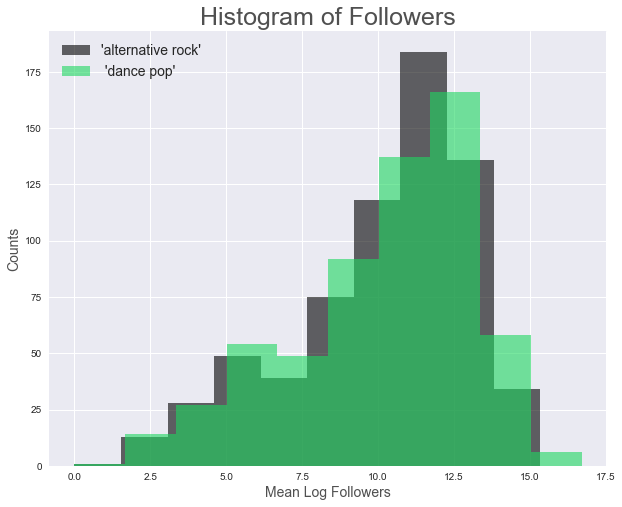

In [51]:
hist_figures()

### Interactions Between Genres and Audio Features

Interaction terms that could potentially provide useful insight are between genres and audio features. These could help answer questions such as: would the number of followers differ for different levels of 'danceability' for dance music vs. rap music? Because the number of genres exceed 100, the genres were first binned into broad genres such as 'house','hip hop','pop','dance','r&b','rap','acoustic','soul'. Then interaction terms were made with these broader genres. 

The following scatterplots and histograms show how the audio features may differ between two very different genres: rap music and dance music. Although it is difficult to observe any distinct differences between the relationship with the interaction terms with the response, we do see that their distributions differ (slightly). For example, rap music seems to be slightly higher in mean energy, and pop music seems to have a slightly higher valence. 

In [39]:
data_broad_genres = pd.read_csv('All_Data.csv')

In [40]:
## Further Preliminary Analysis ##

# Create train and test dataframes from subsample
train_df2, test_df2 = data_splitter(data_broad_genres, train_size)

# Return shapes of train and test dataframes
print("Train Size: {}".format(train_df.shape))
print("Test Size: {}".format(test_df.shape))

Train Size: (1257, 893)
Test Size: (139, 893)


In [41]:
## Further Preliminary Analysis ##

# The numerical columns are standardized next
mean = train_df2[numerical_columns].mean()
std = train_df2[numerical_columns].std()

train_df2[numerical_columns] = (train_df2[numerical_columns] - mean)/std
test_df2[numerical_columns] = (test_df2[numerical_columns] - mean)/std

In [42]:
# Median imputation of missing values
imp = Imputer(missing_values='NaN', strategy='median', axis=1)
train_df2 = pd.DataFrame(imp.fit_transform(train_df2), columns=data_broad_genres.columns)
test_df2 = pd.DataFrame(imp.transform(test_df2), columns=data_broad_genres.columns)

In [52]:
def plot_genre_audio(df, numeric_col, binary_col, colors):
    
    f, axarr = plt.subplots(len(numeric_col),2,figsize=(15,30))
    
    sample_n= int(min(df[binary_col][df[binary_col]!=0].sum(axis=0)))
    

    sample_n = min(sample_n, 900)
    
    for i in range(len(numeric_col)):
        #leg = axarr[i].get_legend()
        
        for j in range(len(binary_col)):
        #m = i%3
        #n = math.floor(i/3)
        
            curr_binary_col = df[df[binary_col[j]]==1].index
            
            samp = random.sample(curr_binary_col.tolist(),  sample_n)
        
            curr_numeric_col = df[numeric_col[i]][samp]
        
            curr_followers = df['Followers_log'][samp]
        
            axarr[i,0].scatter(curr_numeric_col,curr_followers, s = 15, color = colors[j], alpha = 0.5, label=binary_col[j])
            axarr[i,0].legend(fontsize=15)
            axarr[i,0].set_facecolor(white_col)
            axarr[i,0].set_title(numeric_col[i].replace("_"," ") + " vs Followers", fontsize = 20, color = gray_col)
            axarr[i,0].set_xlabel(numeric_col[i].replace("_"," "), fontsize=14, color = med_gray_col)
            axarr[i,0].set_ylabel('Log Followers',fontsize=14, color = med_gray_col)
            
            axarr[i,1].hist(curr_numeric_col.dropna(inplace=False), color = colors[j], alpha = 0.5, bins=20)
            axarr[i,1].set_facecolor(white_col)
            axarr[i,1].set_title('Histogram of ' + numeric_col[i].replace("_"," "), fontsize=20,  color = gray_col)
            axarr[i,0].set_xlabel(numeric_col[i].replace("_"," "), fontsize=14, color = med_gray_col)

In [53]:
num_cols = ['energy_mean','energy_std','valence_mean','valence_std']
genre = ['rap','dance']

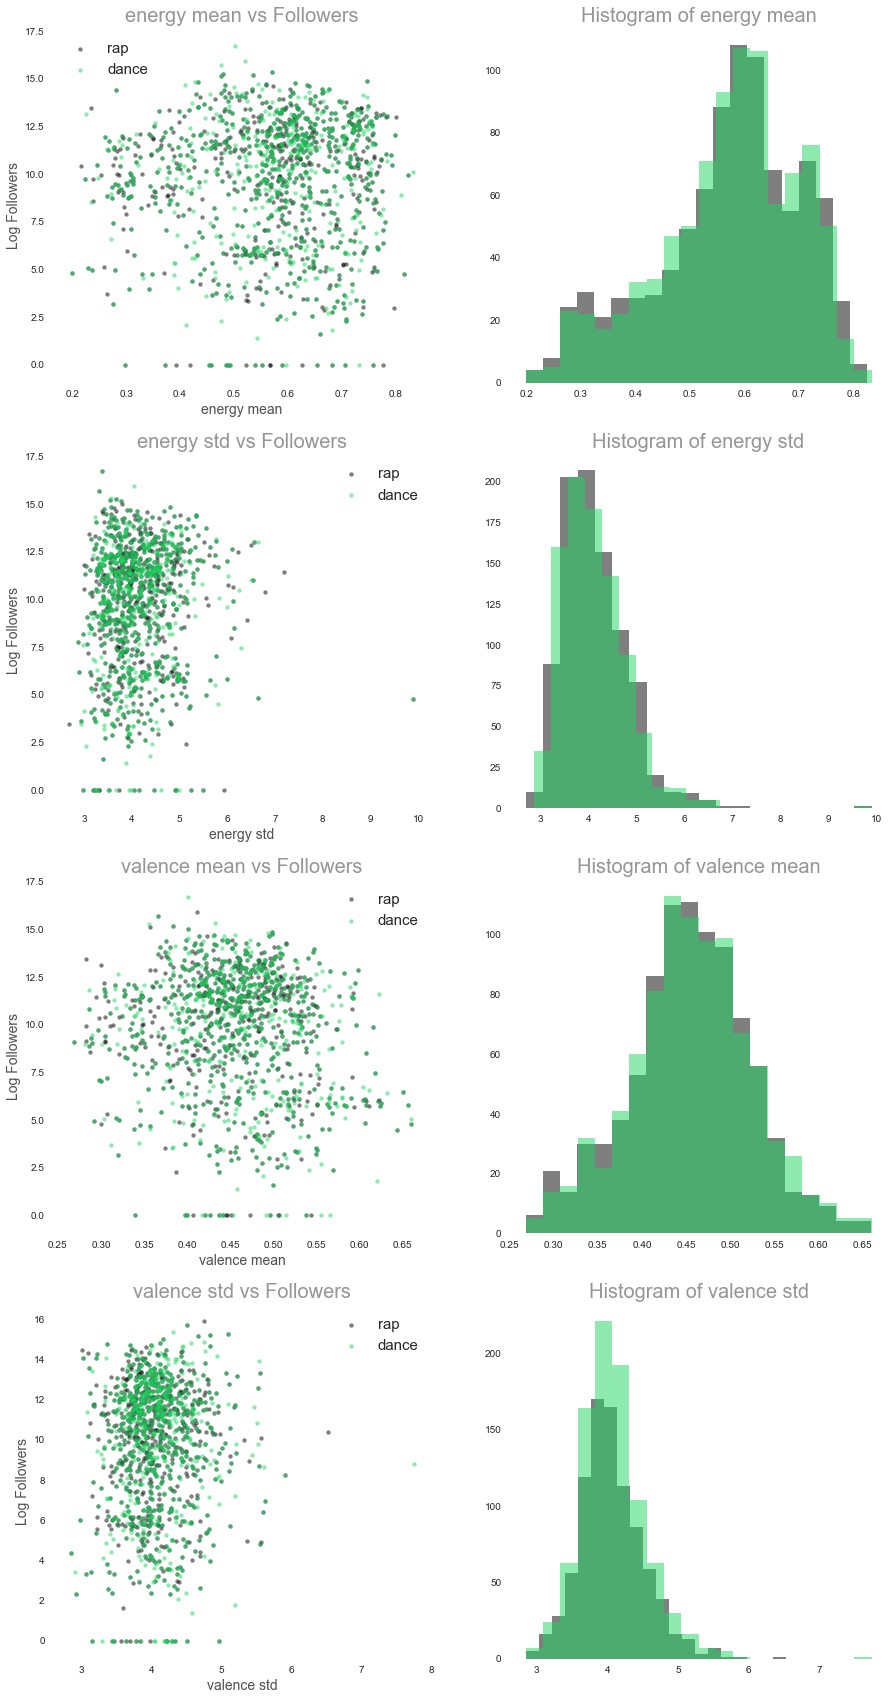

In [54]:
cols = [black_col, green_col]
plot_genre_audio(data_broad_genres, num_cols, genre, cols)

## Artist Features

We think that the presence of  artists who appear most often in popular playlists would be a good predictor for playlist success. To evaluate a playlist's popularity, we found out that a playlist with 35,000+ followers beat 80% of playlist in terms of followers. Therefore, we use 35,000+ as a benchmark. 

In [43]:
artist_followers_df=pd.read_csv('data/artist_level_EDA.csv')

In [68]:
popular_playlist=artist_followers_df[artist_followers_df['playlist followers'] >350000]
highartist=popular_playlist['artist'].value_counts()[1:30]
popular_artists=highartist.index.values
popular_artists

array(['A$AP Rocky', 'Otis Redding', 'Yo Gotti', 'Galantis', 'JAY Z',
       'Led Zeppelin', '21 Savage', 'Chance The Rapper', 'Rihanna',
       'Post Malone', 'Lil Wayne', 'Axwell /\\ Ingrosso', 'Young Thug',
       'Wiz Khalifa', 'Van Morrison', 'Elton John', 'Niall Horan', 'Diddy',
       'Deorro', 'Commodores', 'Radiohead', 'Adele', 'John Mayer', 'Birdy',
       'SYML', 'Ryan Adams', 'Ty Dolla $ign', 'SZA', 'Kanye West'], dtype=object)

In [69]:
followers_popular_artists=[]
for ele in popular_artists:
    followers_popular_artists.append(artist_followers_df[artist_followers_df.artist==ele]['playlist followers'].mean())

In [70]:
follower_artist_dic = dict(zip(popular_artists,followers_popular_artists))
import operator
sorted_x = sorted(follower_artist_dic.items(), key=operator.itemgetter(1))
popular_artists=[]
followers_popular_artists=[]
for ele in sorted_x:
    popular_artists.append(ele[0])
    followers_popular_artists.append(ele[1])

In [78]:
popular_artists.reverse()
followers_popular_artists.reverse()

In [89]:
def top_30():
    y_pos = np.arange(len(popular_artists))
    with sns.plotting_context("poster"): 
        fig, ax1 = plt.subplots(1, 1, figsize=(12, 10))
        ax1 = sns.barplot(x=followers_popular_artists, y=popular_artists, palette="BuGn_r")
        ax1.set_yticklabels(popular_artists, fontsize=12, color=med_gray_col)
        ax1.set_title('Average amount of followers for playlists that include the top 30 artists', fontsize = 20, color = med_gray_col)

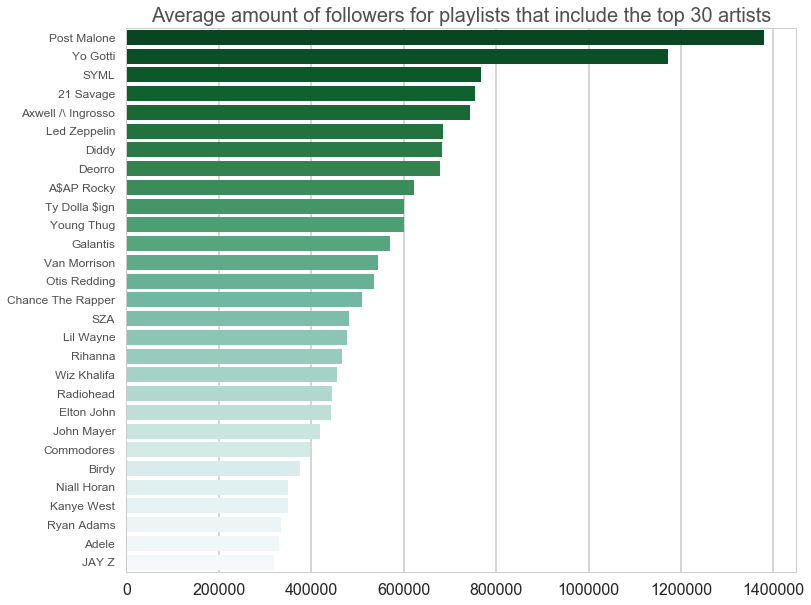

In [90]:
top_30()

We examine the frequency of the artists that appear most often in playlists with 35,000+playlists. We select the top 30 that appear most often. Then, we average the playlist followers that includes such a top artist to examine whether playlist including such artists are indeed more popular. From the graph, we can see that 80% of these artists lead to an average playlist followers of over 40,0000, demonstrating that these artists are potentially good predictors for playlist success.

In [ ]:
def top_30():
    y_pos = np.arange(len(popular_artists))
    with sns.plotting_context("poster"): 
        fig, ax1 = plt.subplots(1, 1, figsize=(12, 10))
        ax1 = sns.barplot(x=followers_popular_artists, y=popular_artists, palette="BuGn_r")
        ax1.set_yticklabels(popular_artists, fontsize=12, color=med_gray_col)
        ax1.set_title('Average amount of followers for playlists that include the top 30 artists', fontsize = 20, color = med_gray_col)

In [130]:
def plot_freq():
    highartist = popular_playlist['artist'].value_counts(ascending=True)[8168:8198]
    highartist = pd.DataFrame(highartist).reset_index()
    highartist = highartist.sort_values(by ='artist', ascending=False)
    with sns.plotting_context("poster"):
        fig, ax1 = plt.subplots(1, 1, figsize=(12, 10))
        ax1 = sns.barplot(x='artist', y='index', data=highartist, palette="BuGn_r")
        ax1.set_yticklabels(highartist['index'], fontsize=12, color=med_gray_col)
        ax1.set_xticklabels(range(0,8), fontsize=12, color=med_gray_col)
        ax1.set_ylabel('Artist', fontsize=14, color=med_gray_col)
        ax1.set_xlabel('Appearance', fontsize=14, color=med_gray_col)
        ax1.set_title('Most Frequently Appeared 30 Artists in Playlists with 350,000+ Followers', fontsize=20, color=med_gray_col)

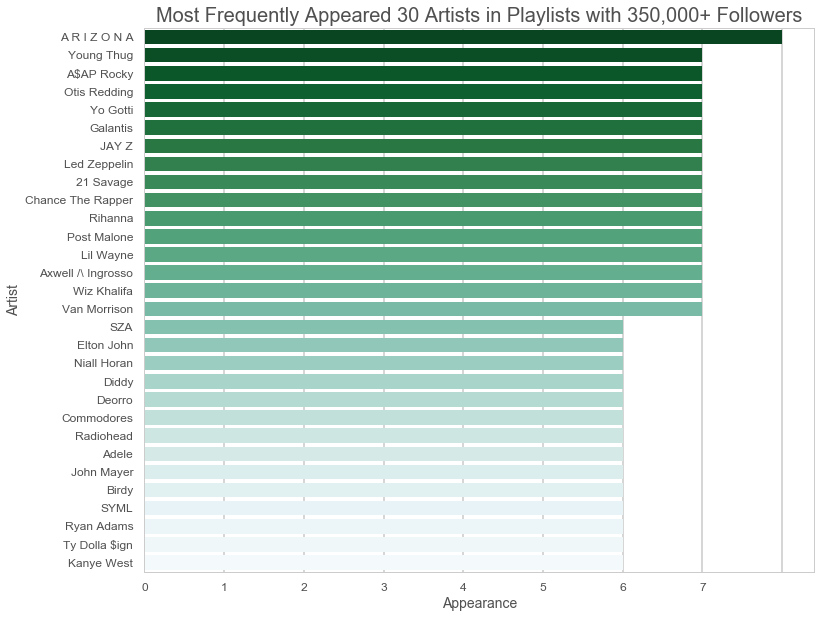

In [131]:
plot_freq()

In [64]:
def mean_artist():
    fig,ax=plt.subplots(1,2,figsize=(15,5))
    ax[0].scatter(train_df[train_df.Followers<200000]['popularity_mean'].values,
              train_df[train_df.Followers<200000]['Followers'].values,color = green_col)
    ax[0].set_title('Log Followers vs the Mean Artist Popularity',fontsize = 18, color = med_gray_col)
    ax[0].set_xlabel('Mean popularity score of artists', fontsize=12, **arfont, color = med_gray_col)
    ax[0].set_ylabel('Playlist followers (log scale)', fontsize=12, **arfont, color = med_gray_col)

    ax[1].scatter(train_df[(train_df.Followers<200000) ]['followers_mean'].values,
              train_df[(train_df.Followers<200000) ]['Followers'].values,color = green_col)
    ax[1].set_title('Log Followers vs the Mean Artist Followers',fontsize = 18, color = med_gray_col)
    ax[1].set_xlabel('Average number of followers for artists', fontsize=12, **arfont, color = med_gray_col)
    ax[1].set_ylabel('Playlist followers (log scale)', fontsize=12, **arfont, color = med_gray_col)


    plt.show()

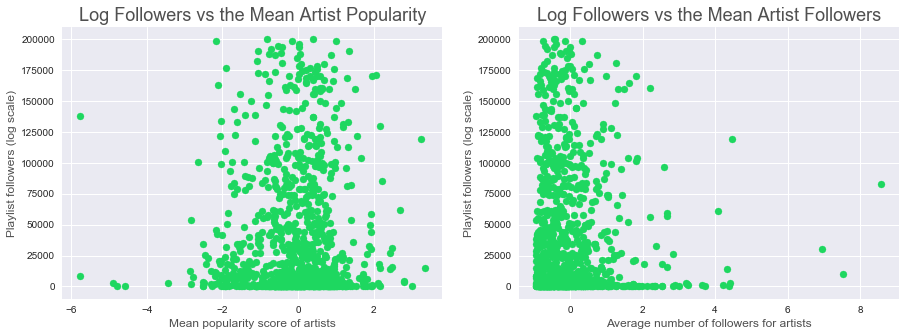

In [65]:
mean_artist()

## Title Features

The last categories that were explored were the titles of the playlists. Spotify users commonly search for certain words in playlist titles, such as "Best of 2017" or "Top Pop Music." Titles were parsed to find certain substrings which were common in titles, and then categorized. For example, the titles containing "top" and "best" belong to the same category (Best). Titles containing "motivation", "exercise", or "workout" were all categorized as workout song titles. The following chart shows the mean followers for these different title categories. It is clear that the "Best" category has a high number of mean followers whereas the older songs of the 20th century have a low number of mean followers. 

In [86]:

title_counts = pd.DataFrame(np.zeros((len(title_columns),4)), 
                             columns=['Num_tracks','Mean_Follow','Total_Follow','Std_Follow'])
title_counts.index = title_columns



print("Counts for Significant Titles: \n")

for pred in title_columns:
    
    pred_cols = train_df[data[pred]==1]
    mean_followers = np.mean(pred_cols['Followers'])
    total_followers = sum(pred_cols['Followers'])
    
    title_counts['Num_tracks'][pred] = sum(train_df[pred])
    title_counts['Mean_Follow'][pred] = round(mean_followers)
    title_counts['Total_Follow'][pred] = round(total_followers)
    title_counts['Std_Follow'][pred] = np.std(pred_cols['Followers'])

title_counts = title_counts.sort_values(['Mean_Follow'], ascending=False)
print(title_counts)

Counts for Significant Titles: 

              Num_tracks  Mean_Follow  Total_Follow    Std_Follow
Str_1970s           15.0     886801.0    10641610.0  2.251041e+06
Str_2000s           56.0     522842.0    25096423.0  2.584003e+06
Str_Chill           22.0     438654.0    10966340.0  1.327551e+06
Str_Acoustic        21.0     231332.0     5089314.0  3.593668e+05
Str_Workout         25.0     212102.0     5514662.0  3.970638e+05
Str_Best            78.0     191977.0    12478475.0  6.122465e+05
Str_1990s           41.0     129461.0     3754367.0  2.250944e+05
Str_Party           16.0     115467.0     1616536.0  1.305883e+05
Str_1960s           17.0      76001.0      912008.0  9.072836e+04
Str_1980s           17.0      59298.0      889464.0  5.708579e+04


In [87]:
# Plot titles

def plot_titles():
    titles = [x[4:] for x in title_columns]
    title_counts.index = titles

    ax1 = title_counts.plot(y = 'Mean_Follow', kind='bar', figsize=(15,8), ylim=(0,900000),legend=False, 
                             color = green_col, width = 0.7, alpha = 0.7)


    ax1.set_facecolor(light_gray_col)
    ax1.grid(True, color = white_col)
    ax1.set_xlabel('Title Categories', fontsize=15, **arfont, color = med_gray_col)
    ax1.set_ylabel('Mean Followers',fontsize=15, **arfont, color = med_gray_col)
    ax1.set_title('Mean Followers of Common Title Categories', fontsize = 25, color=med_gray_col)


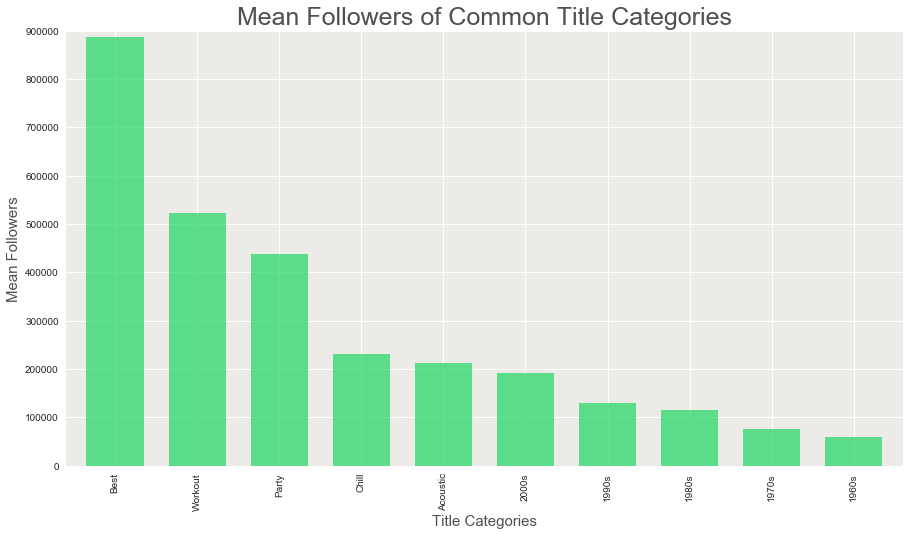

In [88]:
plot_titles()

The following wordcloud visual shows the same categories, in which the image on the left represents the number of playlists in the category (frequency) and the image on the right represents the number of mean followers for playlists of the category (popularity). It is seen that many playlists are from the 2000s or are for working out. Compared to their frequencies, the party and "best" playlists have high popularity. 

In [90]:
#pip install wordcloud
#sudo pip install -r requirements.txt
#python setup.py install

from os import path
from scipy.misc import imread
from wordcloud import WordCloud

num_tracks_df = title_counts['Num_tracks']

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

mean_follow_df = title_counts['Mean_Follow']

def word_cloud():
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=num_tracks_df)
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state = 3), interpolation="bilinear")
    plt.axis("off")
    plt.title('Number of Track Appearances', fontsize=25, color = gray_col)

    wordcloud2 = WordCloud()
    wordcloud2.generate_from_frequencies(frequencies=mean_follow_df)
    plt.subplot(122)
    plt.imshow(wordcloud2.recolor(color_func=grey_color_func, random_state = 3), interpolation="bilinear")
    plt.title('Mean Followers', fontsize=25, color = gray_col)
    plt.axis("off")


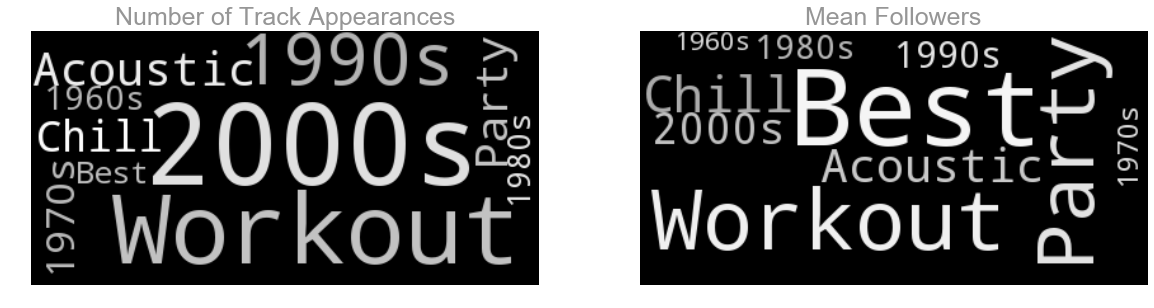

In [91]:
word_cloud()